In [1]:
%matplotlib inline

# Synchronizing Multiple Datasets

This notebook will showcase how one may use the Nowcast Library to synchronize data sets coming from different data sources.

## Imports and Config

In [2]:
import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import nowcastlib as ncl

In [3]:
sns.set_style("ticks")
sns.set_context("notebook")

In [4]:
plt.close("all")

## The Data

To make this notebook independent of external data, let's generate our own. We will generate data from 3 different data sources, and then work with that. The data will have different sample rates, perhaps even be irregular, and will be missing data at different time periods.

First, let's define a function for generating data

In [5]:
def generate_data(
    sr_secs,
    start_date,
    end_date,
    n_cols=1,
    sr_stdev=0,
    gap_period=0,
    gap_size=0,
    gap_size_stdev=0,
    col_names=None
):
    """
    Generates random time series data

    Parameters
    ----------
    sr_secs : int
        The number of seconds between each data point
    start_date : string or datetime.datetime or numpy.datetime64
        When the generated time series should start
    end_date : string or datetime.datetime or numpy.datetime64
        When the generated time series should end
    n_cols : int, default 1
        The number of columns the resulting dataframe should have
    sr_stdev : number, default 0
        The standard deviation in seconds the sample rate should have,
        if an irregular sample rate is desired
    gap_period: int, default 0
        How many seconds of data between gaps, 0 means we never want gaps
    gap_size : int, default 0
        How long a gap should be in seconds
    gap_size_stdev: number, default 0
        The standard deviation in gap size, if the gap size should be irregular
    col_names: list of string, default None
        List of column names the resulting dataframe should have

    Returns
    -------
    pandas.core.frame.DataFrame
        Time-indexed pandas dataframe containing the generated data
    """
    regular_tsteps = np.arange(
        start_date, end_date, step=np.timedelta64(sr_secs, "s"), dtype="datetime64[ms]"
    )
    n_frames = len(regular_tsteps)

    gap_mask = np.ones(n_frames)
    if gap_period > 0:
        assert gap_size > 0, "Can't have 0-length gaps"
        # need to convert from seconds to frames
        gap_size = int(gap_size / sr_secs)
        gap_size_stdev = gap_size_stdev / sr_secs
        gap_period = int(gap_period / sr_secs)

        gappy_section_length = n_frames - 2 * gap_period

        n_gaps = int(gappy_section_length / gap_size)

        deviations = np.random.normal(gap_size, gap_size_stdev, n_gaps) - gap_size
        for i in range(n_gaps):
            curr_index = i * (gap_period + gap_size)
            if (curr_index + gap_size + deviations[i]) < gappy_section_length:
                gap_mask[gap_period:-gap_period][
                    curr_index : curr_index + int(gap_size + deviations[i])
                ] = 0
    gap_mask = gap_mask.astype(bool)

    tsteps = regular_tsteps
    if sr_stdev != 0:
        deviations = (
            np.random.normal(sr_secs, sr_stdev, n_frames - 2) - sr_secs
        ) * 1000
        tsteps[1:-1] += deviations.astype(int)
    gen_data = pd.DataFrame(np.random.randn(n_frames, n_cols), index=tsteps, columns=col_names)
    return gen_data[gap_mask]

In [6]:
df1 = generate_data(
    120,
    "2020-01-01",
    "2020-01-31",
    n_cols=3,
    sr_stdev=30,
    gap_period=7 * 12 * 3600,
    gap_size=12 * 3600,
    gap_size_stdev=3600,
    col_names=["A", "B", "C"]
)
df2 = generate_data(
    110,
    "2020-01-04",
    "2020-02-09",
    n_cols=4,
    sr_stdev=5,
    gap_period=12 * 3600,
    gap_size=6 * 3600,
    gap_size_stdev=1800,
    col_names=["D", "E", "F", "G"]
)
df3 = generate_data(
    300,
    "2019-12-25",
    "2020-01-28",
    n_cols=2,
    sr_stdev=60,
    gap_period=3 * 3600,
    gap_size=3600,
    gap_size_stdev=900,
    col_names=["H", "I"]
)

In [7]:
display("df1")
display(df1.head())
display("df2")
display(df2.head())
display("df3")
display(df3.head())

'df1'

,A,B,C
2020-01-01 00:00:00.000,0.517884,-1.423477,1.835260
2020-01-01 00:02:11.130,-1.007855,-0.948510,-2.346733
2020-01-01 00:03:25.521,0.674186,0.862595,0.892908
2020-01-01 00:05:42.028,-0.747063,-0.505713,0.972643
2020-01-01 00:06:58.268,-0.785092,1.445530,0.707153


'df2'

,D,E,F,G
2020-01-04 00:00:00.000,-0.223412,0.008371,-0.227700,-0.958018
2020-01-04 00:01:47.447,-0.328189,-0.445912,0.809370,-1.746954
2020-01-04 00:03:39.971,1.300763,-1.689650,0.069097,1.245795
2020-01-04 00:05:40.075,0.119366,-0.973595,-2.545897,-1.188041
2020-01-04 00:07:18.990,-0.616945,-0.035096,0.808843,-0.584408


'df3'

,H,I
2019-12-25 00:00:00.000,-1.245650,-1.866255
2019-12-25 00:05:54.553,-0.872302,0.289400
2019-12-25 00:09:13.539,0.202185,-0.268577
2019-12-25 00:16:55.334,-1.123487,0.566743
2019-12-25 00:20:27.086,-0.170613,0.628691


Visualizing the data. Only showing one column from each dataframe since we are mostly interested in the gaps and sampling rate which will be the same across columns of the same dataframe. Two of the dataframes have been vertically shifted to avoid confusion. 

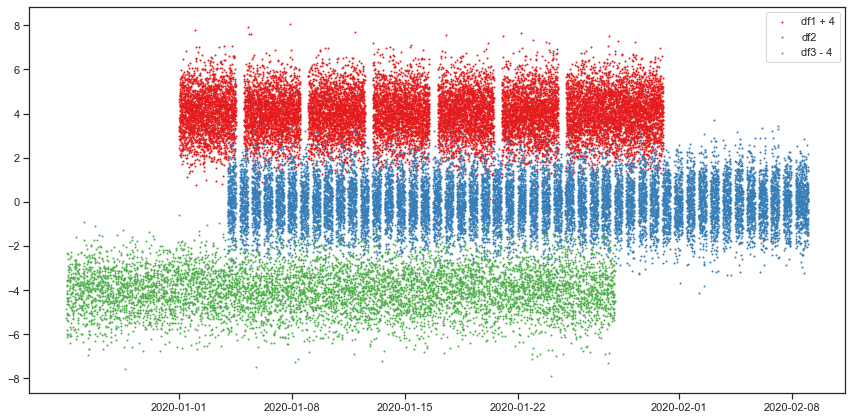

In [8]:
sns.set_palette("Set1")
shift_amount = 4
plt.figure(figsize=(12, 6))
plt.scatter(
    df1.index, df1["A"] + shift_amount, s=1, label="df1 + {}".format(shift_amount)
)
plt.scatter(df2.index, df2["E"], s=1, label="df2")
plt.scatter(
    df3.index, df3["H"] - shift_amount, s=1, label="df3 - {}".format(shift_amount)
)
plt.legend()
plt.tight_layout()
plt.show()

## Processing

### Data Synchronization and Sample-rate regularization

If we want to feed our datasets as a joint input to a time series model, often this requires for the data to be regular, i.e. with a constant sample rate. The datasets will also have to be merged and hence synced (meaning matching sample rates and dates) into a single dataset for whatever model to receive and reason about them as a whole.

We can achieve these two features in the following manner. 

First, we pick a target sample rate. All of our dataframes will be resampled to have this sample rate, so it is best to pick a sample rate that approximates the mean sample rate across the datasets. Two of the three dataframes we are dealing with have a sample rate of \~2 minutes, and the third one has a sample rate of \~5 minutes (I use "\~" because the sample rate is not constant), so let's pick a target sample rate of 2 minutes. In resampling, we also make sure that the resample origin is floored so that each dataframe is resampled from the same starting point. This means that if there are overlaps, they will be exact.|

We then concatenate the resampled dataframes across the 2nd axis (axis=1) by performing an inner join on the index, such that only indices that are shared across all dataframes are kept. This is basically an "intersection" of the indices, if we're thinking in terms of sets.

In [9]:
# config
TARGET_SR = "2min"

In [10]:
# resampling
data_dfs = [df1, df2, df3]
for i, df in enumerate(data_dfs):
     data_dfs[i] = df.resample(TARGET_SR, origin=df.index[0].floor(TARGET_SR)
).mean()

In [11]:
# concatenating
synced_df = pd.concat(data_dfs, axis=1, join="inner")

In [12]:
# result
synced_df.head()

,A,B,C,D,E,F,G,H,I
2020-01-04 00:00:00,-0.240930,0.087790,-0.500263,-0.275801,-0.218770,0.290835,-1.352486,-0.017831,0.983852
2020-01-04 00:02:00,1.071870,1.329469,-0.583281,1.300763,-1.689650,0.069097,1.245795,NaN,NaN
2020-01-04 00:04:00,NaN,NaN,NaN,0.119366,-0.973595,-2.545897,-1.188041,-0.742197,0.946668
2020-01-04 00:06:00,-0.266542,-0.460438,-0.570009,-0.616945,-0.035096,0.808843,-0.584408,NaN,NaN
2020-01-04 00:08:00,NaN,NaN,NaN,-0.720559,-0.632989,-0.176996,-0.084158,NaN,NaN


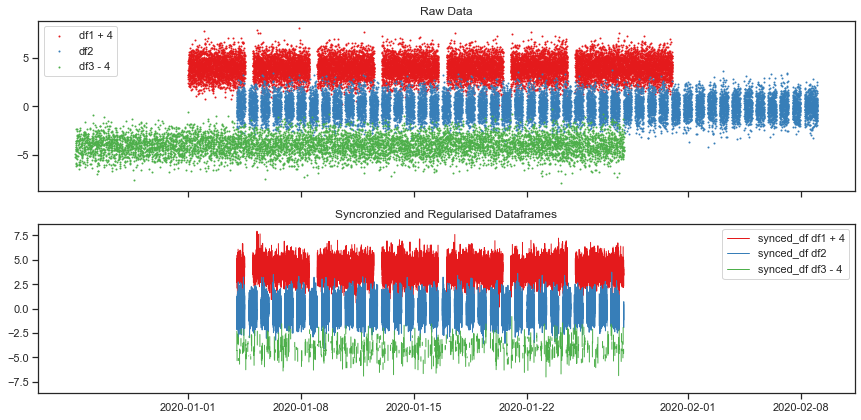

In [13]:
sns.set_palette("Set1")
shift_amount = 4
f, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 6), sharex=True)
ax1.scatter(
    df1.index, df1["A"] + shift_amount, s=1, label="df1 + {}".format(shift_amount)
)
ax1.scatter(df2.index, df2["E"], s=1, label="df2")
ax1.scatter(
    df3.index, df3["H"] - shift_amount, s=1, label="df3 - {}".format(shift_amount)
)
ax1.set_title("Raw Data")
ax1.legend()
ax2.plot(
    synced_df.index,
    synced_df["A"] + shift_amount,
    linewidth=1,
    label="synced_df df1 + {}".format(shift_amount),
)
ax2.plot(
    synced_df.index,
    synced_df["E"],
    linewidth=1,
    label="synced_df df2",
)
ax2.plot(
    synced_df.index,
    synced_df["H"] - shift_amount,
    linewidth=1,
    label="synced_df df3 - {}".format(shift_amount),
)
ax2.set_title("Syncronzied and Regularised Dataframes")
ax2.legend()
plt.tight_layout()
plt.show()

### Finding overlapping data and Handling Gaps

Now that our datasets are synchronized, we need to find when they overlap, i.e. when all three datasets are not null. This is, again, so that we can obtain chunks that our models can treat and reason about as a whole. This is also because our models are not able to handle NaN values in the input.

Normally, we could just find where the gaps are and then perform a set union of the gaps across the datasets. This would give us all the indices where at least one dataset has a gap, which we would then drop. 

However, resampling gave rise to many small gaps, which may be sufficiently small for us to impute with, for example, linear interpolation.

As such, we need to distinguish between small and large gaps. We will keep track of where the large gaps are by producing a boolean mask, impute the entire dataframe, and then drop the indices where the large gaps occurred, using the mask.

---

**Side note**: we may wish to perform additional computations on the data after interpolation which could result in extra columns (such as, for example, computing trigonometric equivalents of particular columns). Because the gap mask has to have the same shape as the dataframe it is being applied to, we need to specify the number of additional columns we expect to add when computing the large gap mask.

In [14]:
# config
# the maximum size of a 'small gap' in seconds. let's say 10 minutes
MAX_SPACING_SECS = 600
# The minimum duration of a contiguous chunk for it to be considered
MIN_CHUNK_DURATION_SEC = 3600

In [15]:
# computing large gap mask
sample_spacing_secs = synced_df.index.freq.delta.seconds
min_chunk_length = int(MIN_CHUNK_DURATION_SEC / sample_spacing_secs)
max_spacing_steps = np.floor((MAX_SPACING_SECS / sample_spacing_secs)).astype(int)
final_mask, chunk_locs = ncl.datasets.compute_dataframe_mask(
    input_df=synced_df,
    max_gap=max_spacing_steps,
    min_length=min_chunk_length,
    additional_cols_n=2,
    column_names=[df.columns[0] for df in data_dfs],
)

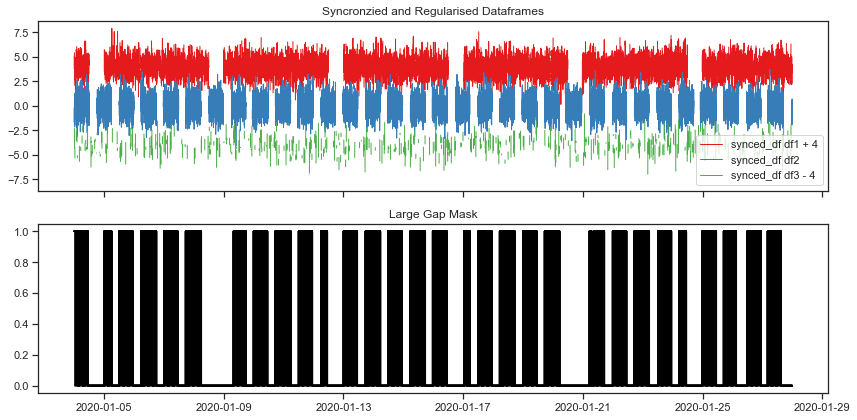

In [16]:
# visualizing our mask
sns.set_palette("Set1")
shift_amount = 4
f, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 6), sharex=True)
ax1.plot(
    synced_df.index,
    synced_df["A"] + shift_amount,
    linewidth=1,
    label="synced_df df1 + {}".format(shift_amount),
)
ax1.plot(
    synced_df.index,
    synced_df["E"],
    linewidth=1,
    label="synced_df df2",
)
ax1.plot(
    synced_df.index,
    synced_df["H"] - shift_amount,
    linewidth=1,
    label="synced_df df3 - {}".format(shift_amount),
)
ax1.set_title("Syncronzied and Regularised Dataframes")
ax1.legend()

ax2.step(synced_df.index, final_mask, label="large gap mask", color='black')
ax2.fill_between(synced_df.index, final_mask[:,0], step='pre', color='black')
ax2.set_title("Large Gap Mask")

plt.tight_layout()
plt.show()
plt.show()

The mask is 0 (or False), where large gaps occur.

In [17]:
# interpolating our data
interpolated_df = synced_df.interpolate("linear", limit_direction="both")
# computing some addtional columns
interpolated_df = ncl.datasets.compute_trig_fields(interpolated_df)

In [18]:
# dropping large gaps using mask
chunked_df = interpolated_df.where(final_mask)

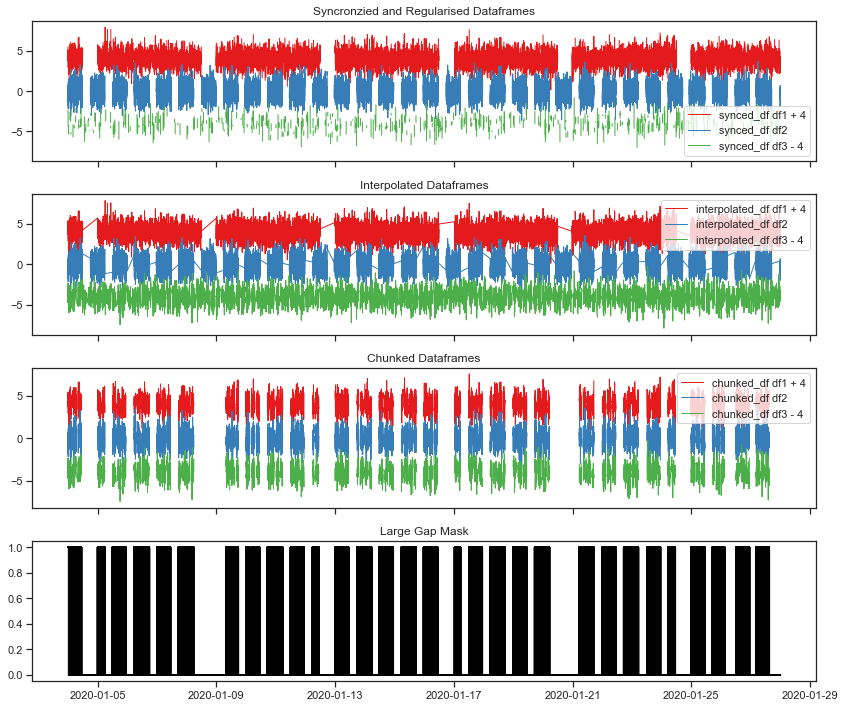

In [19]:
# visualizing
f, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(12, 10), sharex=True)

for df, df_string, title, ax in zip(
    [synced_df, interpolated_df, chunked_df],
    ["synced_df", "interpolated_df", "chunked_df"],
    [
        "Syncronzied and Regularised Dataframes",
        "Interpolated Dataframes",
        "Chunked Dataframes",
    ],
    [ax1, ax2, ax3],
):
    ax.plot(
        df.index,
        df["A"] + shift_amount,
        linewidth=1,
        label="{0} df1 + {1}".format(df_string, shift_amount),
    )
    ax.plot(
        df.index,
        df["E"],
        linewidth=1,
        label="{0} df2".format(df_string, shift_amount),
    )
    ax.plot(
        df.index,
        df["H"] - shift_amount,
        linewidth=1,
        label="{0} df3 - {1}".format(df_string, shift_amount),
    )
    ax.set_title(title)
    ax.legend()

ax4.step(synced_df.index, final_mask, label="large gap mask", color='black')
ax4.fill_between(synced_df.index, final_mask[:,0], step='pre', color='black')
ax4.set_title("Large Gap Mask")

plt.tight_layout()
plt.show()
plt.show()

### Final Cleanup and Saving

Because of the chunk-like aspect of the resulting dataframe, we will split it into individual chunk dataframes, and save these to an HDF5 filestore. In doing so, we can additionally choose to ignore chunks that are shorter than some minimum length.

In [20]:
# config
OUTPUT_PATH = "output/processeddatasets.hdf5"

In [21]:
# chunking. We know where the chunks are located via our mask so we can provide them
chunks = ncl.datasets.make_chunks(chunked_df, chunk_locs)
# providing the second argument to make_chunks is optional, is only there to speed up

In [22]:
# saving to disk
hdfs = pd.HDFStore(OUTPUT_PATH)
for i, chunk in enumerate(chunks):
    chunk.to_hdf(hdfs, "chunk_{:d}".format(i), format="table")

## Conclusion

We have successfully regularized and synchronized 3 different datasets with different irregular sample rates and missing data using functions from the `datasets` submodule of Nowcast Library. We were also able to find exactly where these datasets overlapped, taking into account our preferences in acceptable gap chunk sizes.